<a href="https://colab.research.google.com/github/jeff-ai-ml/genai-langgraph/blob/main/RAG_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph openai langchain_openai langchain-community langchain-chroma

In [5]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

from openai import OpenAI
from google.colab import userdata

In [8]:
llm = ChatOpenAI(model= "gpt-4o-mini", api_key=userdata.get("OPENAI_API_KEY"), temperature = 0)

In [10]:
# Our Embedding Model - has to also be compatible with the LLM
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=userdata.get("OPENAI_API_KEY")
)

In [15]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 5.2 MB/s eta 0:00:00


In [16]:
pdf_path = "Stock_Market_Performance_2024.pdf"


# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise


PDF has been loaded and has 9 pages


In [17]:

# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [18]:
pages_split = text_splitter.split_documents(pages) # We now apply this to our pages

In [21]:
collection_name = "stock_market"
persist_directory = "stock_market_db"

In [22]:
# If our collection does not exist in the directory, we create using the os command
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)


In [24]:
try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")

except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise


# Now we create our retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)


Created ChromaDB vector store!


In [25]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."

    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")

    return "\n\n".join(results)


tools = [retriever_tool]

llm = llm.bind_tools(tools)

In [26]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0


system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""


In [27]:
tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools

In [28]:
# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [29]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [33]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")
rag_agent = graph.compile()

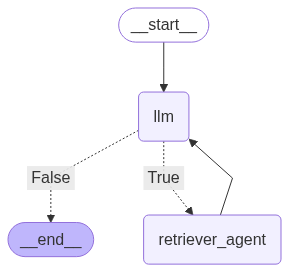

In [34]:
from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [35]:
def running_agent():
    print("\n=== RAG AGENT===")

    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break

        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})

        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


running_agent()


=== RAG AGENT===

What is your question: Which is the best stock of 2024?
Calling Tool: retriever_tool with query: best stock of 2024
Result length: 4587
Tools Execution Complete. Back to the model!

=== ANSWER ===
The best-performing stock of 2024 was Palantir Technologies (PLTR), which saw its stock price soar by approximately 340% throughout the year. This remarkable increase was attributed to the company's successful transition to profitability and its positioning as a key player in artificial intelligence for both government and enterprise sectors. Palantir's share price climbed from single-digit levels at the beginning of the year to the mid-$20s by year-end, reflecting a significant turnaround in investor sentiment (Document 3).

In addition to Palantir, other notable performers included major tech companies like Apple, Alphabet, and Meta, which also contributed to the overall strong performance of the S&P 500, which gained roughly 25% in 2024 (Document 2).

What is your questi